In [25]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Optimization: LQR using shooting for Double Integrator System
# Double Inegrator: F = ma for unit mass 1D system where F => control u 

In [26]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.add("PyPlot")
using LinearAlgebra
using PyPlot

  Activating project at `~/Documents/Optimal_Control/Sims/LQR`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/LQR/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/LQR/Manifest.toml`


In [47]:
#Discrete Dynamics
h = 0.1 #time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [59]:
n = 2 #number of states
m = 1 #number of controls
Tfinal = 5.0 #final time #try larger values
N = Int(Tfinal/h)+1      #number of time steps
thist = Array(range(0, h*(N-1), step=h));

In [60]:
#Initial Conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [61]:
#Cost Weignts
Q = 1.0*I(2)
R = 0.1
#If R is changed to 1, that means I am making controls more expensive so the solution will use less controls
Qn = 1.0*I(2)

2×2 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅ 
  ⋅   1.0

In [70]:
#Cost Function
function J(xhist, uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:, k] + 0.5*uhist[k]'*R*uhist[k]
    end
    return cost
end

J (generic function with 1 method)

In [71]:
function rollout(xhist, uhist)
    xnew = zeros(size(xhist))
    xnew[:,1] = xhist[:,1]
    for k = 1:(N-1)
        xnew[:,k+1] .= A*xnew[:,k] + B*uhist[k]
    end
    return xnew
end

rollout (generic function with 1 method)

In [72]:
#Initial guess
xhist = repeat(x0, 1, N)
uhist = zeros(N-1)
Δu = ones(N-1)
λhist = zeros(n,N)

xhist = rollout(xhist, uhist) #initial rollout to get state trajectory

J(xhist, uhist) #Initial Cost

50.5

In [73]:
b = 1e-2 #line search tolerance
α = 1.0
iter = 0

while maximum(abs.(Δu[:])) > 1e-2 #terminate when gradient is small
    
    #Backward pass to compute λ and Δu
    λhist[:,N] .= Qn*xhist[:,N]
    for k = N-1:-1:1
        Δu[k] = -(uhist[k]+R\B'*λhist[:,k+1])
        λhist[:,k] .= Q*xhist[:,k] + A'*λhist[:,k+1]
    end
    
    #Forward pass with line search to compute x
    α = 1.0
    unew = uhist + α.*Δu
    xnew = rollout(xhist, unew)
    while J(xnew, unew) > J(xhist, uhist) - b*α*Δu[:]'*Δu[:]
        α = 0.5*α
        unew = uhist + α.*Δu
        xnew = rollout(xhist, unew)
    end
    
    uhist .= unew;
    xhist .= xnew;
    iter += 1
end

In [74]:
iter

2416

In [75]:
J(xhist,uhist)

6.658621241414694

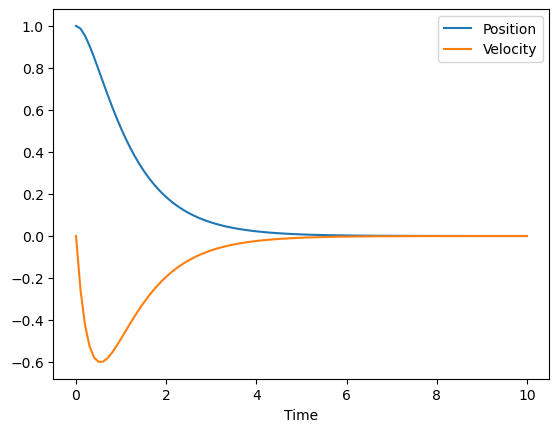

PyObject <matplotlib.legend.Legend object at 0x7f664b2132b0>

In [76]:
#plot x1 vs x2, u vs t
plot(thist, xhist[1,:], label="Position")
plot(thist, xhist[2,:], label="Velocity")
xlabel("Time")
legend()

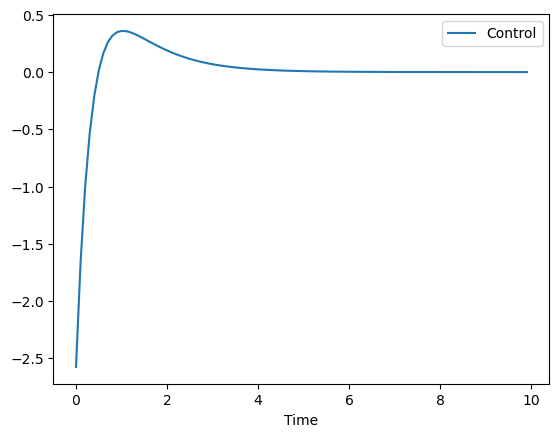

PyObject <matplotlib.legend.Legend object at 0x7f664b19cf40>

In [77]:
plot(thist[1:end-1], uhist, label="Control")
xlabel("Time")
legend()